<a href="https://colab.research.google.com/github/jclary-31/VegetationFromSpace_Landsat2_Sentinel8/blob/main/Multispectral_Satellite_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='landsat-test01')


In [159]:
lat=37
lon=-6

region = ee.Geometry.Rectangle([lon-2, lat-1, lon+2, lat+1])

date_i='2020-07-01'
date_f='2020-09-01'
dates=(date_i,date_f)


# Applies scaling factors.
def Landsat_apply_factors(image):
  '''
   Apply scale factors to Landsat 8 satellite
   function taken on earh engine Data catalog for landsat T1_L2
  '''
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)       ##surface reflectance bands
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)    ## surface temperature bans
  return image.addBands(optical_bands, None,overwrite= True).addBands(
      thermal_bands, None,overwrite= True
  )

def Sentinel_apply_factors(image):
    '''
    Apply scale factor to Sentinel2 satellite
    this could be done without additionnal function, I made it to be consistent with
    the procedure for Landsat 8 satellite
    '''
    return image.divide(10000)



def  getCollection(sat,dates,region):
    if sat=='era5':
        sat_id='ECMWF/ERA5_LAND/HOURLY' #land hourly data ; weather related data
    elif sat=='landsat':
        sat_id= 'LANDSAT/LC08/C02/T1_L2'#  Landsat 8, collection 2, niveau 1 uniquement
    elif sat=='sentinel':
        sat_id='COPERNICUS/S2_HARMONIZED' #the harmonized prodcut, better?
    else:
        print('no Sat')
        return
    #
    mySat= ee.ImageCollection(sat_id)\
        .filterDate(dates[0],dates[1]) \
        .filterBounds(region) \
        #.filter(ee.Filter.listContains('system:time_start'))
        #.first()#Returns the first entry from a given collection. for test


    #scaling factors must be applied on the whole collection
    if sat_id=='landsat':
      mySat=mySat.map(Landsat_apply_factors)
    elif sat_id=='sentinel':
      mySat=mySat.map(Sentinel_apply_factors)

    ##REMOVE too cloudy image,
    # not for Era5  as it a a reanalysis
    #keep image with less than x% of cloud / remove too cloudy images
    if sat_id=='sentinel':
        mySat=mySat.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))

    if sat_id=='landsat':
      mySat=mySat.filter(ee.Filter.lt('CLOUD_COVER', 60))
    return mySat


######################## PIXEL QA cleaning##################################
def Sent_QAmask(image):
    '''
    Remove pixel with bad quality and pixel with cloud
    For Sentinel 2 satellite
    NO saturation mask is applied, I don't know if it is possible
    '''
    quality_band = image.select('QA60')
    cloudmask = 1<<10
    cirrusmask = 1<<11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) \
    and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    #saturation mask is?
    return image.updateMask(mask)


def Land_QAmask(image):
    '''
    Remove pixel with bad quality and pixel with cloud
    For Landsat2 satellite
    A saturation mask is also applied
    #see https://developers.google.com/earth-engine/tutorials/community/time-series-modeling
    #see https://gis.stackexchange.com/questions/405056/understanding-the-cloud-mask-in-google-earth-engine
    '''
    quality_band = image.select('QA_PIXEL')
    cloudmask = 1 << 4
    cloudshadowmask = 1 << 5
    mask = quality_band.bitwiseAnd(cloudshadowmask).eq(0) \
    and (quality_band.bitwiseAnd(cloudmask).eq(0))
    saturationMask = image.select('QA_RADSAT').eq(0)
    return image.updateMask(mask).updateMask(saturationMask)




def poi_mean(img):
    '''
    Compute spatial average on a point of interest (small area) for all bands
    '''
    mean = img.reduceRegion(reducer=ee.Reducer.mean(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('mean',mean)
#
def poi_median(img):
    '''
    Compute spatial median on a point of interest (small area) for all bands
    '''
    median = img.reduceRegion(reducer=ee.Reducer.mean(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('median',median)


def poi_std(img):
    '''
    Compute spatial standard deviation on a point of interest (small area) for all bands
    '''
    mean = img.reduceRegion(reducer=ee.Reducer.stdDev(),
                             geometry=poi,
                             bestEffort=True,
                             scale=30,
                             maxPixels=1e9
                             )
    return img.set('date', img.date().format()).set('std',std)



def ImageColl_toDataFrame(ImageCollection,poi,method):
    '''
    Extract data for all bands and stack them into a dataframe
    '''
    if method=='mean':
        ImageColl_=ImageCollection.map(poi_mean)
    elif method=='std':
        ImageColl_=ImageCollection.map(poi_std)
    elif method=='median':
        ImageColl_=ImageCollection.map(poi_median)
    #
    reduced=ImageColl_.reduceColumns(ee.Reducer.toList(2), ['date',method]).values().get(0)
    data_sat=reduced.getInfo()
    #
    Df=dataSat_toDataFrame(data_sat)
    return Df


def dataSat_toDataFrame(data_sat):
    '''
    A code used in ImageColl_toDataFrame to transform satellite extracted data into a dataframe
    '''
    Q=pd.DataFrame()
    for i in range(len(data_sat)):
        time=data_sat[i][0]
        data=data_sat[i][1]
        testedkey=list(data.keys())[1]#could be other than 1, I just need a value to test
        if data[testedkey] is not None:
            q=pd.DataFrame.from_dict(data,orient='index').T
            q['time']=time
            Q=pd.concat([Q,q])
    #
    Q.index=Q.pop('time')
    return Q





####################COMPUTE spectralindex


#index
#search on https://custom-scripts.sentinel-hub.com/custom-scripts/
#or on https://www.bikeshbade.com.np
#or on https://esri.com
#oron https://www.earthdatascience.org
def compute_ndvi(image):
    '''
    Compute Normalized Difference Vegetation Index
    photosynthetically active biomass / vegetation health
    NDVI = (NIR-RED)/(NIR+RED)
    '''
    ndvi = image.normalizedDifference([BAND['nir'], BAND['red']]).rename('NDVI')
    return image.addBands(ndvi)


def compute_ndwi(image):
    '''
    Compute Normalized Difference Water Index # also called NDMI where M=moisture
    change in the water content of leaves /moisture index /water stress and drought
    NDWI = (NIR-SWIR1)/(NIR+SWIR1)
    '''
    ndwi = image.normalizedDifference([BAND['nir'], BAND['swir1']]).rename('NDWI')
    return image.addBands(ndwi)


def compute_bsi(image):
    '''
    Compute Bare Soil Index
    quantify soil mineral composition and land degradation ;crop identification?
    BSI=((RED + SWIR) - (NIR + BLUE)) / ((RED + SWIR) + (NIR + BLUE))
    '''
    bsi= image.expression('((RED + SWIR) - (NIR + BLUE)) / ((RED + SWIR) + (NIR + BLUE))',
                           {'NIR' : image.select(BAND['nir']),
                            'RED' : image.select(BAND['red']),
                            'BLUE': image.select(BAND['blue']),
                            'SWIR' : image.select(BAND['swir2'])
                            }
                            ).rename('BSI')
    return image.addBands(bsi)


def compute_satvi(image):
    '''
    Compute soil adjusted total vegetation Index
    vegetation index  as ndvi but more stable and reduce the impact of soil brightness on vegetation
    SATVI= ((SWIR1 - RED) / (SWIR1 + RED + L)) * (1 + L) - (SWIR2 / 2)
    L= 0.5 or 1 usually, L= 0.5 here
    see https://medium.com/@muhammad.shahnoor/remote-sensing-soil-indices-google-earth-engine-8234511d730d
    '''
    satvi=image.expression('((SWIR1 - RED) / (SWIR1 + RED + L)) * (1 + L) - (SWIR2 / 2)',
                           {'SWIR1': image.select(BAND['swir1']),
                            'RED': image.select(BAND['red']),
                            'SWIR2': image.select(BAND['swir2']),
                            'L': 0.5
                            }
                            ).rename('SATVI')
    return image.addBands(satvi)


def compute_evi(image):
  '''
  Enhanced Vegetation Index ; ndvi but modified to enchance vegetation signal
  https://en.wikipedia.org/wiki/Enhanced_vegetation_index
  between -1 and 1
  EVI = 2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))
  '''
  evi=image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                          {'NIR': image.select(BAND['nir']),
                          'RED': image.select(BAND['red']),
                          'BLUE': image.select(BAND['blue'])
                          }
                          ).rename('EVI')
  return image.addBands(evi)


def compute_lai(image):
  '''
  Leaf Area Index
  see https://kaflekrishna.com.np/blog-detail/retrieving-leaf-area-index-lai-sentinel-2-image-google-earth-engine-gee/
  require previous calculation of EVI, formula base on a blog... not very sure if it is correct
  '''
  lai=image.expression('3.618*EVI-0.118',
                      {'EVI':image.select('EVI')}
                        ).rename('LAI')
  return image.addBands(lai)


def compute_gndvi(image):
  '''
  Green Normalized Difference Vegetation Index
  see https://www.soft.farm/en/blog/vegetation-indices-ndvi-evi-gndvi-cvi-true-color-140
  '''
  gndvi = image.normalizedDifference([BAND['nir'], BAND['green']]).rename('GNDVI')
  return image.addBands(gndvi)


def compute_cvi(image):
  '''
  Chlorophyll Vegetation Index
  see https://www.soft.farm/en/blog/vegetation-indices-ndvi-evi-gndvi-cvi-true-color-140
  '''
  cvi=image.expression('NIR*RED/GREEN/GREEN',
                        {'NIR':image.select(BAND['nir']),
                         'RED':image.select(BAND['red']),
                         'GREEN':image.select(BAND['green'])
                        }).rename('CVI')

  return image.addBands(cvi).addBands(cvi)






##########################################################
##########################################################
############################# END of function definitions




############################# GET DATA, apply QA, compute spectralindex

#1 - get data
Era5=getCollection('era5',dates,region)
Landsat=getCollection('landsat',dates,region)
Sentinel=getCollection('sentinel',dates,region)

Landsat=Landsat.map(Land_QAmask)
Sentinel=Sentinel.map(Sent_QAmask)

#2 - Bands names
#band_era=Era5.first().bandNames().getInfo() #same as bandnames, ok ; meteo  for later
band_LS=Landsat.first().bandNames().getInfo() #band B1 to B12 + QA_PIXEL+QA_RADARSAT +others
band_Sent=Sentinel.first().bandNames().getInfo() #band B1 to B11 + some QA +others

#sentinel bands
codes = ['QA60','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']
names = ['QA60','blue','green','red','re1','re2','re3','nir','re4','waterVapor','cirrus','swir1','swir2']
S_BAND=dict([(n,c) for c,n in zip(codes,names)])

#landsat 8 bands
#this not l2level codes=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']#, 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA']
#this is not l2 level names=['Coastal','blue','green','red','nir','swir1','swir2','pan','cirrus','tirs1','tirs2']
#see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#bands
codes=['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
names=['Coastal','blue','green','red','nir','swir1','swir2'] # Ithink
L8_BAND=dict([(n,c) for c,n in zip(codes,names)])


#3 - compute index
BAND=S_BAND
Sentinel=Sentinel.map(compute_ndvi)
Sentinel=Sentinel.map(compute_ndwi)
Sentinel=Sentinel.map(compute_bsi)
Sentinel=Sentinel.map(compute_satvi)
Sentinel=Sentinel.map(compute_evi)
Sentinel=Sentinel.map(compute_lai)
Sentinel=Sentinel.map(compute_gndvi)
Sentinel=Sentinel.map(compute_cvi)


BAND=L8_BAND
Landsat=Landsat.map(compute_ndvi)
Landsat=Landsat.map(compute_ndwi)
Landsat=Landsat.map(compute_bsi)
Landsat=Landsat.map(compute_satvi)
Landsat=Landsat.map(compute_evi)
Landsat=Landsat.map(compute_lai)
Landsat=Landsat.map(compute_gndvi)
Landsat=Landsat.map(compute_cvi)


#############################  2D MAP visualisation parameters

palette0=[ 'yellow', 'green','blue']
palette1 = [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']
#vis_params = {"min":0.0, "max":1,"palette": ['B4','B3','B2']}



#Map = geemap.Map(center=[lat, lon],zoom=6)

#image.getInfo()

In [178]:
vis_params={'min': -.1, 'max': 1,
            'palette': palette1}

#features are NDVI,NDWI,BSI,SATVI,EVI,LAI,GNDVI,CVI
#problem with SATVI
feature='GNDVI'


image=Landsat.median().clip(region)
#print(image.select(feature))
Map = geemap.Map()
Map.centerObject(region, 8)
Map.addLayer(image.select(feature), vis_params, 'Landsat')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map.add_colorbar(vis_params,layer_name=feature,label=feature)
Map



Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

In [180]:
#same index or band but for Sentinel

image=Sentinel.median().clip(region)
Map = geemap.Map()
Map.centerObject(region, 8)
Map.addLayer(image.select(feature), vis_params, 'Landsat')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map


Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
image.bandNames().getInfo()


Minmax=image.select('B8').reduceRegion(ee.Reducer.minMax(),geometry=region).values().getInfo()
print (Minmax)

#Sentinel.toList(4).getInfo()[0]['properties']

[2866, 288]


In [181]:
# Visualisation with false color for Sentinel
# see https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/

image_viz_params = {
    'bands': ['B8', 'B4', 'B3'],
    'min': 0,
    'max': 3500,
    'gamma': [0.95, 1.1, 1],
}

# Define a map centereon area of interest
Map = geemap.Map()
Map.centerObject(region, 8)
Map.add_layer(image, image_viz_params, 'false color composite')
fc = ee.FeatureCollection(region)
style = {'color': 'ffff00ff', 'fillColor': '00000000'}
Map.addLayer(fc.style(**style), {}, 'ROI')
Map



Map(center=[37.01238799549964, -5.999999999999887], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# code to save some figure locally, both in jpg and in tif
#download data to '/content' in collab and in local directory on a computer
#8-10mn to run, unfortunatley, increase scale in tif to reduce time

def save_figure(image,satname,vis_params,feature):
    #
    #save image in local, as tif
    projection = image.select(0).projection().getInfo()
    geemap.ee_export_image(image.select(feature),
                            filename=satname+'_'+feature+'.tif',
                            scale=1000, #higher mean less computation time
                            crs=projection['crs'], #useful?
                            region=region
                           )


    #save image in local, as jpg
    out_img=satname+'_'+feature+'.jpg'
    geemap.get_image_thumbnail(image.select(feature),
                                out_img,
                                vis_params=vis_params,
                                dimensions=512,
                                region=region)
    geemap.show_image(out_img)


############### Save figure
image=Sentinel .median().clip(region)
satname='Sentinel'
save_figure(image,satname,vis_params,feature='NDVI')
save_figure(image,satname,vis_params,feature='NDWI')
save_figure(image,satname,vis_params,feature='BSI')
save_figure(image,satname,vis_params,feature='SATVI')


image=Landsat .median().clip(region)
satname='Landsat'
save_figure(image,satname,vis_params,feature='NDVI')
save_figure(image,satname,vis_params,feature='NDWI')
save_figure(image,satname,vis_params,feature='BSI')
save_figure(image,satname,vis_params,feature='SATVI')



Generating URL ...
Please wait ...
Data downloaded to /content/Sentinel_NDVI.tif


Output()

Generating URL ...
Please wait ...
Data downloaded to /content/Sentinel_NDWI.tif


Output()

Generating URL ...
Please wait ...
Data downloaded to /content/Sentinel_BSI.tif


Output()

Generating URL ...
Please wait ...
Data downloaded to /content/Sentinel_SATVI.tif


Output()

Generating URL ...
Please wait ...
Data downloaded to /content/Landsat_NDVI.tif


Output()

Generating URL ...
Please wait ...
Data downloaded to /content/Landsat_NDWI.tif


Output()

Generating URL ...
Please wait ...
Data downloaded to /content/Landsat_BSI.tif


Output()

Generating URL ...
Please wait ...
Data downloaded to /content/Landsat_SATVI.tif


Output()

In [183]:
#make animated gif!




collecting mean values at given point


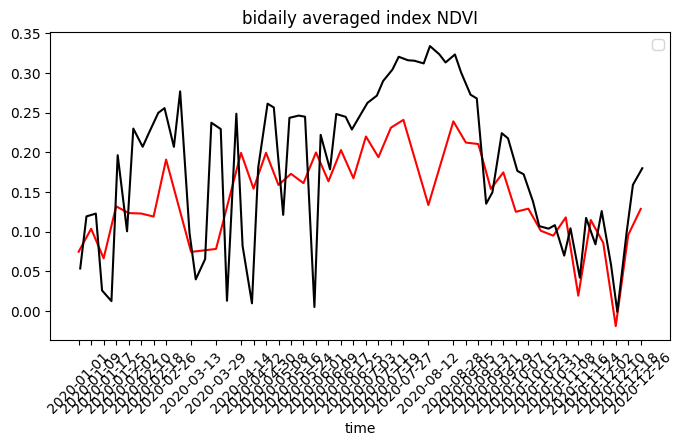

In [190]:
################################################################################################
################################################################################################
#################################### TIME SERIE ################################################
#I need long time here but a 'small' area
feature='NDVI' # index to analyze or a spectral band

poi = ee.Geometry.Point(lon,lat).buffer(10000) #point of interest with 10000m buffer circle area

date_i='2020-01-01'
date_f='2021-01-01' # I need one year at least to be able to do harmonic decomposition ('seasonal')
dates=(date_i,date_f)

Landsat=getCollection('landsat',dates,region)
Sentinel=getCollection('sentinel',dates,region)

Landsat=Landsat.map(Land_QAmask)
Sentinel=Sentinel.map(Sent_QAmask)

BAND=S_BAND
Sentinel=Sentinel.map(compute_ndvi)
Sentinel=Sentinel.map(compute_ndwi)
Sentinel=Sentinel.map(compute_bsi)
Sentinel=Sentinel.map(compute_satvi)

BAND=L8_BAND
Landsat=Landsat.map(compute_ndvi)
Landsat=Landsat.map(compute_ndwi)
Landsat=Landsat.map(compute_bsi)
Landsat=Landsat.map(compute_satvi)




#redo but on years and on point of interest, not whole large area

print('collecting mean values at given point')

method='median'
#Era5_df=ImageColl_toDataFrame(Era5,poi,method)
Land_df=ImageColl_toDataFrame(Landsat,poi,method)
Sent_df=ImageColl_toDataFrame(Sentinel,poi,method)

# convert time to timestamp
Land_df.index=pd.to_datetime(Land_df.index,utc=True)
Sent_df.index=pd.to_datetime(Sent_df.index,utc=True)

#daily resample
#Land_df=Land_df.groupby(Land_df.index.date).mean() # groupy remove time as a timestamp
#Sent_df=Sent_df.groupby(Sent_df.index.date).mean()
Land_df=Land_df.resample('2D',axis=0).mean().dropna(subset=Land_df.columns[0])
Sent_df=Sent_df.resample('2D',axis=0).mean().dropna(subset=Sent_df.columns[0])

#timeserie
timeformat='%Y-%m-%d'
timelabel=[x.strftime(timeformat) for x in Land_df.index]#less timestamp with landsat


fig,ax=plt.subplots(figsize=(8,4))
ax.plot(Land_df.index,Land_df[feature],'r')
ax.plot(Sent_df.index,Sent_df[feature],'k')
ax.legend('Landsat8','Sentinel2')
ax.set_xlabel('time')
ax.set_xticks(Land_df.index, labels=timelabel)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('bidaily averaged index '+ feature )
fig.show()




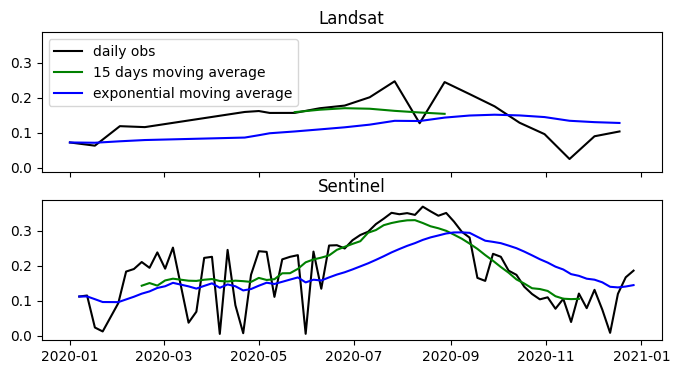

In [ ]:

####rolling mean of 15d? and/or exponential moving average?
#to do
#rolling mean
window = 15  # 15-day moving average
win_typ='boxcar'#or'hanning' #default is boxcar
Land_rma = Land_df.rolling(window=window,win_type=win_typ,center=True).mean()
Sent_rma = Sent_df.rolling(window=window,win_type=win_typ,center=True).mean()
#exponential moving average
Land_ema = Land_df.ewm(halflife=window/2, adjust=False,ignore_na=True).mean()
Sent_ema = Sent_df.ewm(halflife=window/2, adjust=False,ignore_na=True).mean()

fig,ax=plt.subplots(2,figsize=(8,4),sharex=True,sharey=True)
ax[0].plot(Land_df.index,Land_df[feature],'k',label='daily obs')
ax[0].plot(Land_rma.index,Land_rma[feature],'g',label='15 days moving average')
ax[0].plot(Land_ema.index,Land_ema[feature],'b',label='exponential moving average')
ax[0].set_title('Landsat')
ax[0].legend()

ax[1].plot(Sent_df.index,Sent_df[feature],'k')
ax[1].plot(Sent_rma.index,Sent_rma[feature],'g')
ax[1].plot(Sent_ema.index,Sent_ema[feature],'b')
ax[1].set_title('Sentinel')

fig.show()



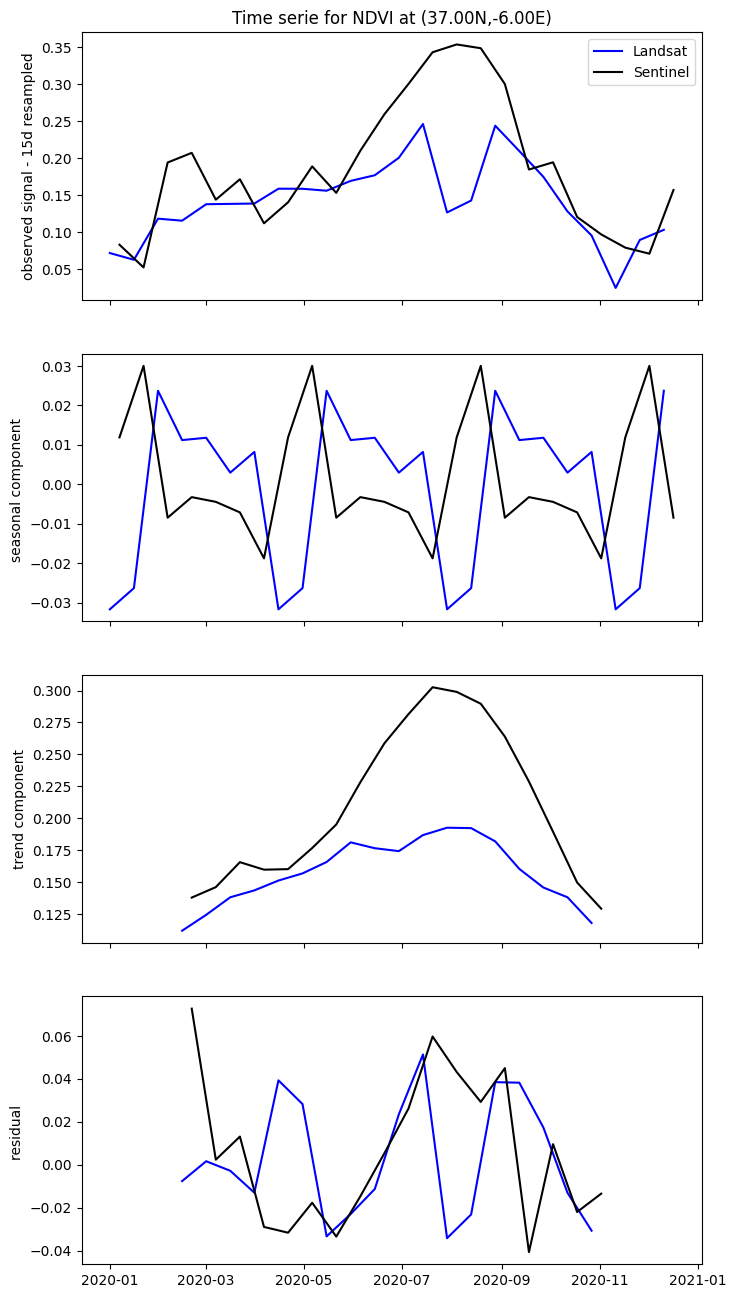

In [ ]:


### time serie decomposition!
#see https://www.geeksforgeeks.org/python/time-series-decomposition-techniques/
# and https://phdinds-aim.github.io/time_series_handbook/Preface/Preface.html

#resample on 15d and interpolate to remove few remaining nan.
Sent_df15d=Sent_df.resample('15d').mean().interpolate(method='spline',order=1)
Land_df15d=Land_df.resample('15d').mean().interpolate(method='spline',order=1)

Sent_decomp = seasonal_decompose(Sent_df15d[feature], model='additive')
Land_decomp = seasonal_decompose(Land_df15d[feature], model='additive')


fig,ax=plt.subplots(4,1,figsize=(8,16),sharex=True)
ax[0].plot(Land_decomp.observed,'b',label='Landsat')
ax[0].plot(Sent_decomp.observed,'k',label='Sentinel')
ax[0].set_ylabel('observed signal - 15d resampled')
ax[0].legend()
ax[0].set_title('Time serie for '+ feature +' at ('+ '{:0.2f}'.format(lat) +'N,'+ '{:0.2f}'.format(lon) +'E)')

ax[1].plot(Land_decomp.seasonal,'b')
ax[1].plot(Sent_decomp.seasonal,'k')
ax[1].set_ylabel('seasonal component ')

ax[2].plot(Land_decomp.trend,'b')
ax[2].plot(Sent_decomp.trend,'k')
ax[2].set_ylabel('trend component')


ax[3].plot(Land_decomp.resid,'b')
ax[3].plot(Sent_decomp.resid,'k')
ax[3].set_ylabel('residual ')

fig.show()



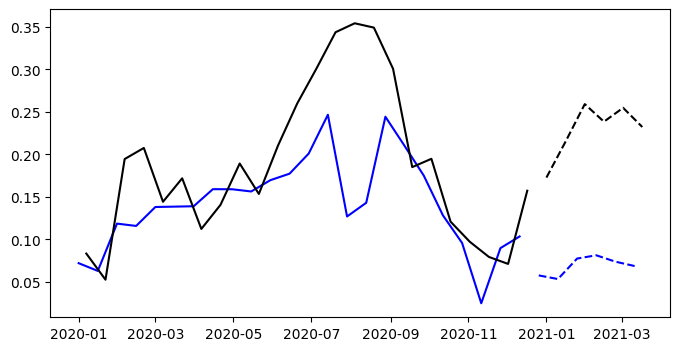

In [ ]:

############################################## PREDICTION
#by using ARIMA algorithm
# ARIMA= Autoregressive Integrated Moving Average
#https://medium.com/@hazallgultekin/time-series-analysis-and-forecasting-with-arima-8be02ba2665a
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
from statsmodels.tsa.arima.model import ARIMA

#ordre=(p,q,d) The parameters of the ARIMA model are defined as follows:
#    p: The lag order, representing the number of lag observations incorporated in the model.
#    d: Degree of differencing, denoting the number of times raw observations undergo differencing.
#    q: Order of moving average, indicating the size of the moving average window.
ordre=(4, 1, 2)

#define optimal order p,d,q ???

nstep=round(Sent_df15d.shape[0]/4)

model = ARIMA(Land_df15d[feature], order=ordre)
model_fit = model.fit()
# Forecast next n time step, here a timestep=15days
Land_forecast = model_fit.forecast(steps=nstep)

model = ARIMA(Sent_df15d[feature], order=ordre)
model_fit = model.fit()
# Forecast next n time step, here a timestep=15days
Sent_forecast = model_fit.forecast(steps=nstep)

####

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(Land_df15d.index,Land_df15d[feature],'b')
ax.plot(Sent_df15d.index,Sent_df15d[feature],'k')
ax.plot(Land_forecast.index,Land_forecast,'b',linestyle='dashed')
ax.plot(Sent_forecast.index,Sent_forecast,'k',linestyle='dashed')

fig.show()


In [ ]:
#### WATER DECTECTION, i.e image classification , with ResNet34???
#to do
